# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [1]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
#!pip install --upgrade scipy==1.7.3

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 272 (delta 21), reused 25 (delta 11), pack-reused 236
Receiving objects: 100% (272/272), 2.98 MiB | 6.60 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [197]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import norm

# Bayesian Optimization



## Create function to optimize

Here we first create an originator function that's nonlinear with addition of noise.

In [321]:
# Fix seed
np.random.seed(42)
# Function definition
xgrid = np.round(np.arange(-3,3,0.01),4)
def f(x,eps=0):
    return -1*np.power(x,4)+0.5*np.power(x,3)+6*np.power(x,2)+0.5*np.power(x,1)-6+eps*np.random.normal(0,1,x.size)


In [322]:
# Plot function to optimize
fgrid = f(xgrid)
fig = px.line(x=xgrid,y=fgrid,title="Function to Optimize")
fig.update_yaxes(range=[-10, 10])
fig.show()

The goal is to find maximum. If we could sample unlimited times our datapoints x, we could just look up the answer.

In [323]:
maxloc = np.argmax(f(xgrid))
maxval = xgrid[maxloc]
maxfun = f(maxval)
print('The maxium is at x = ',maxval)
print('The value of f at that point is y = ',maxfun)

The maxium is at x =  1.95
The value of f at that point is y =  [7.03843125]


### Add experimental points

Define initial experimental points

In [324]:
# Control of noise level
eps = 0.5
# Define experimental observations
x = np.arange(-3,0.5,0.5)

In [325]:
# Obtain observation measurments with noise
y = f(x,eps)
# Plot funcition with measurments
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10),name='Measurements'))
fig.update_yaxes(range=[-10, 10])
fig.update_layout(title="Unknown function with measurments",xaxis_title="x",yaxis_title="y")
fig.show()

### Fit gaussian process model

We use gausian processes with standard normal kernel to learn the function above given those measurments.

In [326]:
# Define Model
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(x.reshape(-1,1), y.reshape(-1,1)) 
# Use model to make predictions
xpred = xgrid
ypred = np.zeros((3,len(xpred)))
for n in range(len(xpred)):
    (mean,std)=gpr.predict(xgrid[n].reshape(-1,1),return_std=True) 
    ypred[1,n] = mean.flatten()
    ypred[0,n] = mean.flatten()-2*std.flatten()
    ypred[2,n] = mean.flatten()+2*std.flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.



In [328]:
# Plot predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color=px.colors.qualitative.G10[3]),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color=px.colors.qualitative.G10[0]),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color=px.colors.qualitative.G10[1]),name='Measurements'))
fig.update_yaxes(range=[-10, 10])
fig.update_xaxes(range=[-3, 3])
fig.update_layout(title="Learned function from observations",xaxis_title="x",yaxis_title="y")
fig.show()

# Define acquisition function

Acquisition function represent our objective.



## Probability of improvement.

A example of good acquisition function is a probability of improvement.

To demonstrate it, let's evaluate the function at some new point.

In [329]:
# New measurments
xnew = 1

In [330]:
# Obtain prediction at the new point
(ynew_mean,ynew_std) = gpr.predict(np.array(xnew).reshape(1,-1),return_std=True)
print('Predicted mean and std at x = '+str(xnew))
print("Mean: ",float(ynew_mean))
print("Std: ",float(ynew_std))

Predicted mean and std at x = 1
Mean:  10.422362845362386
Std:  10.013013082135775


We compare now this prediction with actual maximal value observed so far.

In [331]:
# Actual maximum value
y_max = np.max(y)
print("Observed maximum function value so far at y = "+str(round(y_max,4)))

Observed maximum function value so far at y = 0.0244


### Compute distribution

Therefore we compute distribution of possible values. Since we know our prediction at each new point `xnew` is normally distributed with `xnew_mean` and `xnew_std`, we can plot the full distribution at the new point. 

This distribution represents possible observations according to the model. The solid red line represents a so far actualy observed maximum value `y_max`.




In [333]:
# Compute normal distribution
xdist = np.random.randn(100000)*float(ynew_std) + float(ynew_mean)
hist_data = [xdist]
group_labels = ['Conditional Distribution'] 

# Plot distribution
fig = ff.create_distplot(hist_data, group_labels,curve_type='normal',show_hist=False, show_rug=False)
fig.add_vline(x=float(ynew_mean),line=dict(color='green'),annotation=dict(text="Mean",textangle=90))
fig.add_vline(x=float(ynew_mean)+float(ynew_std),line=dict(color='green',dash='dash'),annotation=dict(yanchor="bottom",text="Std",textangle=90))
fig.add_vline(x=float(ynew_mean)-float(ynew_std),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
fig.add_vline(x=float(y_max),line=dict(color='red'),annotation=dict(xanchor="right",text="Observed Maximum Value",textangle=90))
fig.update_layout(title="Conditional distribution at x = "+str(xnew),showlegend=True,xaxis_title="x",yaxis_title="pdf")
fig.show()


Now we compute the accquisition function based on the conditional probability distribution as probability of improvement. That is a probability of observing a value from the conditional distribution greater than the observed maximum value is:

In [300]:
# Probability of improvement
PI = 1-norm(float(ynew_mean), float(ynew_std)).cdf(y_max)
print("Probability of Improvement = "+str(PI))

Probability of Improvement = 0.8504678256089069


### Compute acquisition for all x

Now we compute the acquisition function for all x values


In [308]:
# Calculate PI (Probability of Improvement)
pigrid = np.zeros_like(xgrid)
for n in range(len(xgrid)):
    pigrid[n] = 1-norm(float(ypred[1,n]), float((ypred[1,n]-ypred[0,n])/2)).cdf(y_max)

In [346]:
# Plot acquisition function (PI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=pigrid,mode='lines',line=dict(color='red'),name='Probability of Improvement'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes(range=[0,1], secondary_y=True,title_text="Probability of Improvement")
fig.update_layout(title="Acquisition function (Probability of Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


Given the defined acquisition function, then next point we would like to observe a measurment from is value for which the acquisition function is the highest.

In [335]:
pimaxloc = np.argmax(pigrid)
pimaxval = xgrid[pimaxloc]
pimaxfun = pigrid[pimaxloc]
print('The maximum PI is at x = ',pimaxval)
print('The Prob of improvement at that point is y = ',pimaxfun)

The maximum PI is at x =  1.19
The Prob of improvement at that point is y =  0.8613476680004005


## Expected improvement

Here we modify our acquisition function to be an expected improvement. That is an actual value of the function by which we expect to improve discounted by their conditional probabilities.


In [339]:
# Calculate EI (Expected Improvement)
eigrid = np.zeros_like(xgrid)
xi = 0.1
for n in range(len(xgrid)):
    sigma = float((ypred[1,n]-ypred[0,n])/2)
    zscore = (float(ypred[1,n])-y_max-xi) / sigma
    phiz = norm(0,1).cdf(zscore)
    eigrid[n] = (float(ypred[1,n])-y_max-xi)*phiz + sigma*phiz

In [345]:
# Plot acquisition function (EI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eigrid,mode='lines',line=dict(color='red'),name='Expected Improvement'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Expected Improvement")
fig.update_layout(title="Acquisition function (Expected Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


## Exploration / Exploitation

You can define your own acquisition function. The function demonstrated below is a balanced approach between exploration and exploitation which is driven by parameter $\kappa$ = `kappa`. The values correspond to the upper confidence bounds.



In [348]:
# Explore-Exploit parameter
kappa = 0.5

In [349]:
# Calculate EE (Explore-Exploit)
eegrid = ypred[1,:] + kappa*((ypred[1,n]-ypred[0,n])/2)

In [350]:
# Plot acquisition function (EE)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eegrid,mode='lines',line=dict(color='red'),name='Explore-Exploit'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Explore-Exploit")
fig.update_layout(title="Acquisition function (Explore-Exploit) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


# Run Bayesian Optimization

Now that we have have defined the optimization problem, we can run the bayesian optimization and see if we are able to iteratively find the maximum possible value.

In [353]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.7 MB/s 


In [354]:
from skopt import gp_minimize


In [374]:
# Specify noise level
eps = 0.5
# Function to optimize
def f(x,eps=eps):
    return -1*float(-1*np.power(x,4)+0.5*np.power(x,3)+6*np.power(x,2)+0.5*np.power(x,1)-6+eps*np.random.normal(0,1,np.array(x).size))

In [407]:
# Run bayesian optimization
res = gp_minimize(f,                  # the function to minimize
                  [(-3.0, 3.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  verbose=False,       # the verbosity of progress
                  random_state=np.random.seed(47))   # the random seed

In [408]:
print("Optimal point found by optimizaiton: "+str(round(res.x[0],4)))
print("Functional vallue at optimum: "+str(-1*round(res.fun,4)))

Optimal point found by optimizaiton: 1.8708
Functional vallue at optimum: 7.1369


## Convergence Plot

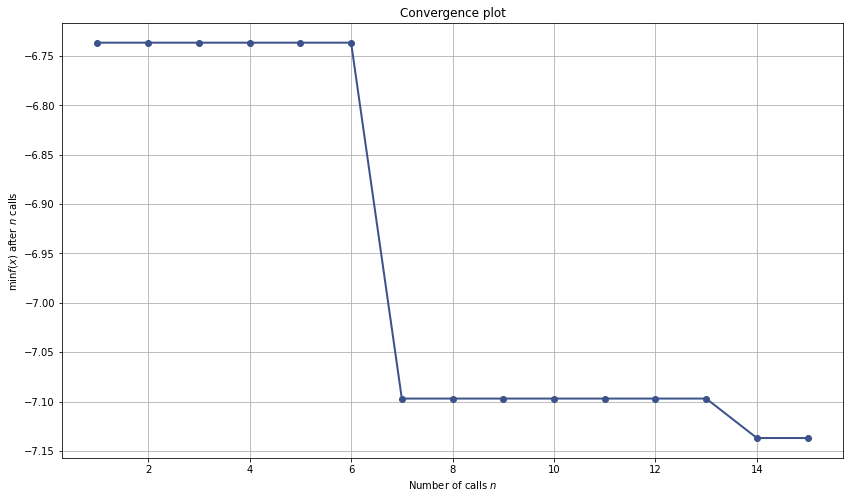

In [409]:
from skopt.plots import plot_convergence
plt.rcParams["figure.figsize"] = (14, 8)

plot_convergence(res);


## Approximation evolution

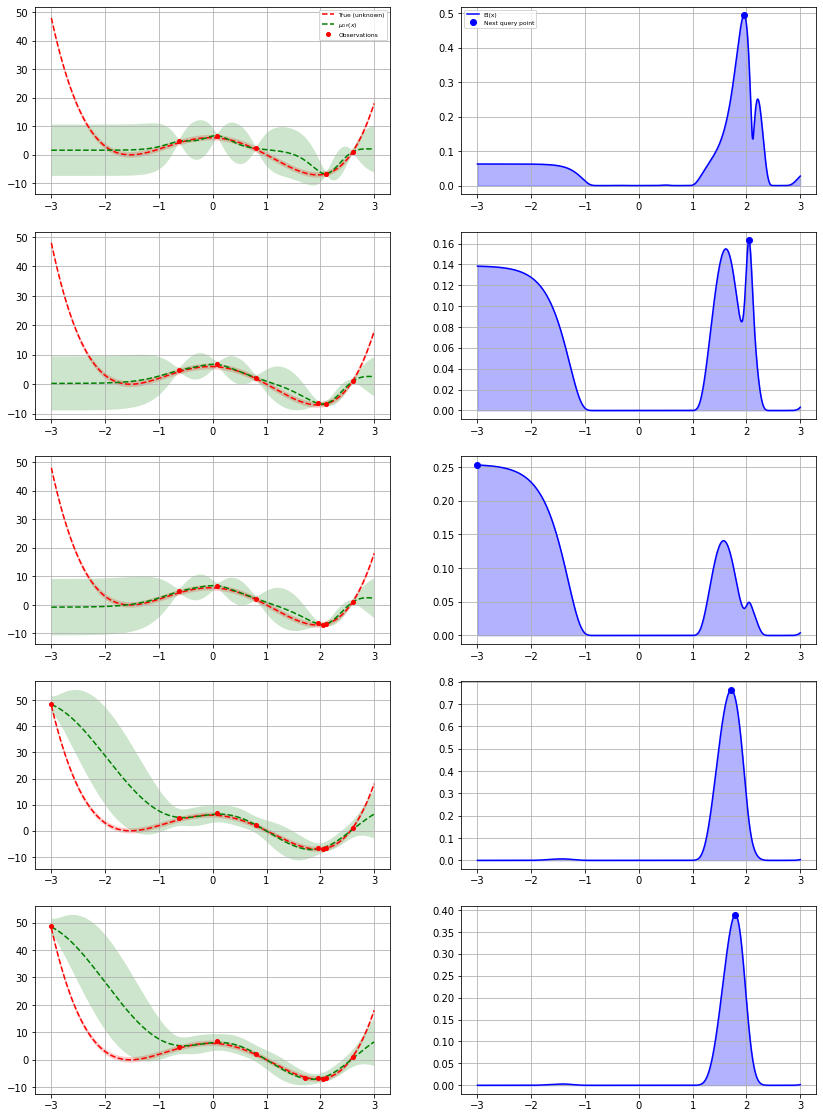

In [410]:
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

plt.rcParams["figure.figsize"] = (14, 20)

def f_wo_noise(x):
    return f(x, eps=0)

for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=eps,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

## Learned function with confidence intervals

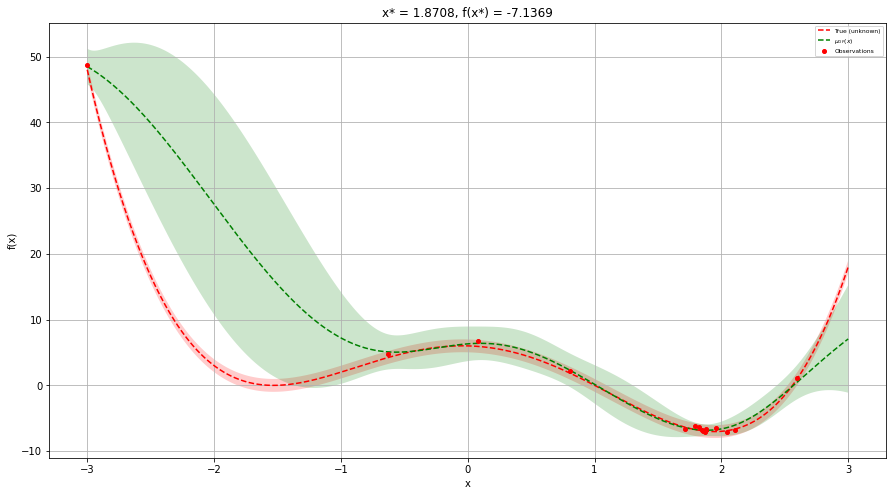

In [411]:
plt.rcParams["figure.figsize"] = (15, 8)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=eps)

plt.show()
